<a href="https://www.kaggle.com/code/digvijayyadav/otto-collaborative-recommender-system?scriptVersionId=114590920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import cudf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import cupy
import glob
import time
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading and Analyzing JSON Data

We will begin by loading json data with a small subset of around 100k as the original dataset is quite big, and we may run out of RAM computing that.

In [2]:
%%time
train_df = pd.DataFrame()
chunks = pd.read_json('/kaggle/input/otto-recommender-system/train.jsonl', lines=True, chunksize=100_000)

for chunk in chunks:
    event_dict = {'session': [], 'aid': [], 'ts': [], 'type': []}
    
    for session, events in zip(chunk['session'].tolist(), chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    train_df = pd.DataFrame(event_dict)
    
    break
        
train_df = train_df.reset_index(drop=True)
train_df

CPU times: user 11.9 s, sys: 2.61 s, total: 14.5 s
Wall time: 16.7 s


,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
5227648,99999,1544954,1660373630318,clicks
5227649,99999,1032408,1660373656430,clicks
5227650,99999,1544954,1660373678083,clicks
5227651,99999,554230,1660373715477,clicks


**We observe that there are three types of events here clicks, carts and orders, so let's check if there are any correlation amongst these events, since we are looking at an Multi-Objective Recommender System, we would want to be able to estabilish how the user's purchasing history was determined for generating better recommendations.**

**Since the features in consideration are categorical variables, we will use 2x2 contingency table and `corr()` metrics to estabilish correlation.**

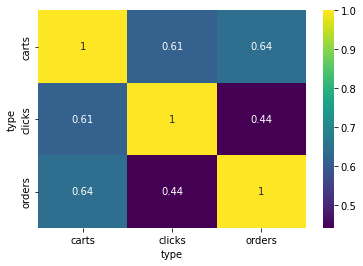

In [3]:
ct = pd.crosstab(index = train_df['session'],columns=train_df['type'])

sns.heatmap(ct.corr(), cmap='viridis', annot=True)
plt.show()

**we observe that there is 61% probability of clicks being put into carts. 64% probability that the items in carts are being ordered.** 

In [4]:
del train_df, ct 

# Loading Data and Creating a Recommender System based on Matrix Factorization

**We will proceed with using the otto-full-optimized-memory-footprint dataset since it is a compressed version with libraries like Merlin, and cuDF, we will proceed with creating a model**.

In [5]:
#we need to create columns specifically for type, time-stamps and aid which is the unique id
# lets time the process
%time

train_df = cudf.read_parquet('/kaggle/input/otto-full-optimized-memory-footprint/train.parquet')
test_df = cudf.read_parquet('/kaggle/input/otto-full-optimized-memory-footprint/test.parquet')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


We need to create aid-aid pairs to train our matrix factorization model!

Let's us grab the pairs both from the train and test set.

In [6]:
%time
train_pairs = cudf.concat([train_df, test_df])[['session','aid']]

del train_df, test_df

train_pairs['aid_next'] = train_pairs.groupby('session').aid.shift(-1)
train_pairs = train_pairs[['aid', 'aid_next']].dropna().reset_index(drop=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


cardinality means possible values the feature can assume, so here it is possible that 'aid' column can have many values.

In [7]:
cardinality_aids = max(train_pairs['aid'].max(), train_pairs['aid_next'].max())
cardinality_aids

1855602

In [8]:
!pip install merlin-dataloader==0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 167.9 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 440.2 kB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Installing build dependencies ... - \ 

In [9]:
from merlin.loader.torch import Loader 

train_pairs[:-10_000_000].to_pandas().to_parquet('train_pairs.parquet')
train_pairs[-10_000_000:].to_pandas().to_parquet('valid_pairs.parquet')

In [10]:
from merlin.loader.torch import Loader 
from merlin.io import Dataset

train_ds = Dataset('train_pairs.parquet')
train_dl_merlin = Loader(train_ds, 65536, True)

In [11]:
%time

for batch in train_dl_merlin:
    aid1, aid2 = batch[0], batch[1]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


# Matrix Factorization

**referencing the implementations of https://www.kaggle.com/code/cpmpml/matrix-factorization-with-gpu**

In [12]:
import torch
from torch import nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_aids, n_factors):
        super().__init__()
        self.aid_factors = nn.Embedding(n_aids, n_factors, sparse=True)
        
    def forward(self, aid1, aid2):
        aid1 = self.aid_factors(aid1)
        aid2 = self.aid_factors(aid2)
        
        return (aid1 * aid2).sum(dim=1)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

valid_ds = Dataset('valid_pairs.parquet')
valid_dl_merlin = Loader(valid_ds, 65536, True)

In [13]:
from torch.optim import SparseAdam

num_epochs=10
lr=0.01

model = MatrixFactorization(cardinality_aids+1, 32)
optimizer = SparseAdam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [14]:
%%time
model.to('cuda')
for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        aid1 = aid1.to('cuda')
        aid2 = aid2.to('cuda')
        output_pos = model(aid1, aid2)
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        output = torch.cat([output_pos, output_neg])
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)])
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')

01: * TrainLoss 0.621  * Accuracy 0.671
02: * TrainLoss 0.604  * Accuracy 0.698
03: * TrainLoss 0.595  * Accuracy 0.709
04: * TrainLoss 0.593  * Accuracy 0.714
05: * TrainLoss 0.591  * Accuracy 0.718
06: * TrainLoss 0.590  * Accuracy 0.720
07: * TrainLoss 0.587  * Accuracy 0.721
08: * TrainLoss 0.588  * Accuracy 0.722
09: * TrainLoss 0.588  * Accuracy 0.723
10: * TrainLoss 0.587  * Accuracy 0.724
CPU times: user 3min 58s, sys: 3.93 s, total: 4min 2s
Wall time: 4min 4s


In [15]:
#getting the embeddings
%time
embeddings = model.aid_factors.weight.detach().cpu().numpy()

from cuml.neighbors import NearestNeighbors


knn = NearestNeighbors(n_neighbors=21, metric='euclidean')
knn.fit(embeddings)

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 16 µs


NearestNeighbors()

In [16]:
%time

_, aid_nns = knn.kneighbors(embeddings)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [17]:
from collections import defaultdict

sample_sub = pd.read_csv('../input/otto-recommender-system//sample_submission.csv')
test = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

session_types = ['clicks', 'carts', 'orders']
gr = test.reset_index(drop=True).to_pandas().groupby('session')
test_session_AIDs = gr['aid'].apply(list)
test_session_types = gr['type'].apply(list)

labels = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}
for AIDs, types in zip(test_session_AIDs, test_session_types):
    if len(AIDs) >= 20:
        # if we have enough aids (over equals 20) we don't need to look for candidates! we just use the old logic
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        aids_temp=defaultdict(lambda: 0)
        for aid,w,t in zip(AIDs,weights,types): 
            aids_temp[aid]+= w * type_weight_multipliers[t]
            
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        labels.append(sorted_aids[:20])
    else:
        # here we don't have 20 aids to output -- we will use approximate nearest neighbor search and our embeddings
        # to generate candidates!
        AIDs = list(dict.fromkeys(AIDs[::-1]))
        
        # let's grab the most recent aid
        most_recent_aid = AIDs[0]
        
        # and look for some neighbors!
        nns = list(aid_nns[most_recent_aid])
                        
        labels.append((AIDs+nns)[:20])

In [18]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [19]:
submission

,session_type,labels
0,12899779_clicks,59625 59625 550061 40333 1175332 139381 151093...
1,12899780_clicks,1142000 736515 973453 582732 1142000 1531941 5...
2,12899781_clicks,918667 199008 194067 57315 141736 918667 17547...
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...
...,...,...
5015404,14571577_orders,1141710 1141710 884342 707990 503322 61105 184...
5015405,14571578_orders,519105 519105 1514524 645357 871924 1769577 88...
5015406,14571579_orders,739876 739876 1156032 1459498 621470 938821 99...
5015407,14571580_orders,202353 202353 1231403 190356 1212504 184728 88...
